In [3]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [4]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [5]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)
tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
labels_per_class = 'full' # full

### Load packages

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load dataset

In [8]:
from tfumap.load_datasets import load_MNIST, mask_labels
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_MNIST(flatten=False)
X_train.shape

(50000, 28, 28, 1)

In [9]:
if labels_per_class == "full":
    X_labeled = X_train
    Y_masked = Y_labeled = Y_train
else:
    X_labeled, Y_labeled, Y_masked = mask_labels(
        X_train, Y_train, labels_per_class=labels_per_class
    )

### Network architecture

In [10]:
dims = (28,28,1)
n_components= 2

### Test model with just UMAP

In [11]:
from tfumap.semisupervised import find_a_b
from tfumap.umap import convert_distance_to_probability

In [12]:
min_dist = 0.001
_a, _b = find_a_b(min_dist)
_a, _b 

(<tf.Tensor: shape=(), dtype=float32, numpy=1.9290735>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.79150456>)

##### build iterator

In [13]:
from tfumap.semisupervised import build_fuzzy_simplicial_set
from tfumap.umap import compute_cross_entropy, get_graph_elements

In [14]:
n_neighbors = 15  # default = 15
umap_graph = build_fuzzy_simplicial_set(
    X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:]))),
    #y=Y_masked,
    n_neighbors=n_neighbors,
)

In [15]:
umap_graph.nnz

1030710

In [16]:
n_epochs = 200
graph, epochs_per_sample, head, tail, weight, n_vertices = get_graph_elements(
            umap_graph, n_epochs
)
batch_size = 1000 #10000

In [17]:
max_sample_repeats_per_epoch = 25
# set the maximum number of times each edge should be repeated per epoch
epochs_per_sample = np.clip(
    (weight / np.max(weight)) * max_sample_repeats_per_epoch,
    1,
    max_sample_repeats_per_epoch,
).astype("int")

In [18]:
edges_to_exp, edges_from_exp = (
        np.repeat(head, epochs_per_sample.astype("int")),
       np.repeat(tail, epochs_per_sample.astype("int")),
)
shuffle_mask = np.random.permutation(range(len(edges_to_exp)))
edges_to_exp = edges_to_exp[shuffle_mask]
edges_from_exp = edges_from_exp[shuffle_mask]

In [19]:
edges_to_exp = np.expand_dims(edges_to_exp, 1)
edges_from_exp = np.expand_dims(edges_from_exp, 1)

In [20]:
negative_sample_rate = 5

In [21]:
def gather_X(edge_to, edge_from):
    return (tf.gather(X_train, edge_to), tf.gather(X_train, edge_from)), 0

In [22]:
edge_iter = tf.data.Dataset.from_tensor_slices((edges_to_exp, edges_from_exp))
edge_iter = edge_iter.shuffle(10000)
#edge_iter = edge_iter.map(gather_X, num_parallel_calls=tf.data.experimental.AUTOTUNE)
edge_iter = edge_iter.batch(batch_size, drop_remainder=True)
edge_iter = edge_iter.prefetch(100)

In [23]:
a, b = next(iter(edge_iter))

### initialize embedding

In [24]:
from umap.spectral import spectral_layout

from sklearn.utils import check_random_state

random_state = check_random_state(None)
metric = "euclidean"
_metric_kwds = {}
def init_embedding_from_graph(_raw_data, graph, n_components, random_state, metric, _metric_kwds, init="spectral"):
        """ Initialize embedding using graph. This is for direct embeddings. 

        Parameters
        ----------
        init : str, optional
            Type of initialization to use. Either random, or spectral, by default "spectral"

        Returns
        -------
        embedding : np.array
            the initialized embedding
        """
        if isinstance(init, str) and init == "random":
            embedding = random_state.uniform(
                low=-10.0, high=10.0, size=(graph.shape[0], n_components)
            ).astype(np.float32)
        elif isinstance(init, str) and init == "spectral":
            # We add a little noise to avoid local minima for optimization to come

            initialisation = spectral_layout(
                _raw_data,
                graph,
                n_components,
                random_state,
                metric=metric,
                metric_kwds=_metric_kwds,
            )
            expansion = 10.0 / np.abs(initialisation).max()
            embedding = (initialisation * expansion).astype(
                np.float32
            ) + random_state.normal(
                scale=0.0001, size=[graph.shape[0], n_components]
            ).astype(
                np.float32
            )

        else:
            init_data = np.array(init)
            if len(init_data.shape) == 2:
                if np.unique(init_data, axis=0).shape[0] < init_data.shape[0]:
                    tree = KDTree(init_data)
                    dist, ind = tree.query(init_data, k=2)
                    nndist = np.mean(dist[:, 1])
                    embedding = init_data + random_state.normal(
                        scale=0.001 * nndist, size=init_data.shape
                    ).astype(np.float32)
                else:
                    embedding = init_data

        return embedding

In [25]:
embedding = init_embedding_from_graph(X_train, graph, n_components, random_state, metric, _metric_kwds, init="spectral")

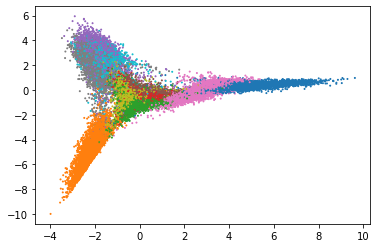

In [26]:
plt.scatter(embedding[:,0], embedding[:,1], c=Y_train, s=1, cmap=plt.cm.tab10)

#### Build network

In [27]:
def umap_loss(batch_size, negative_sample_rate, _a, _b, repulsion_strength = 1.0):
    #@tf.function
    def loss(placeholder_y, embed_to_from):
        # split out to/from
        embedding_to, embedding_from = tf.split(embed_to_from, num_or_size_splits=2, axis=1)

        # get negative samples
        embedding_neg_to = tf.repeat(embedding_to, negative_sample_rate, axis=0)
        repeat_neg = tf.repeat(embedding_from, negative_sample_rate, axis=0)
        embedding_neg_from = tf.gather(
            repeat_neg, tf.random.shuffle(tf.range(tf.shape(repeat_neg)[0]))
        )

        #  distances between samples (and negative samples)
        distance_embedding = tf.concat(
            [
                tf.norm(embedding_to - embedding_from, axis=1),
                tf.norm(embedding_neg_to - embedding_neg_from, axis=1),
            ],
            axis=0,
        )

        # convert probabilities to distances
        probabilities_distance = convert_distance_to_probability(
            distance_embedding, _a, _b
        )
        
        # set true probabilities based on negative sampling
        probabilities_graph = tf.concat(
            [tf.ones(batch_size), tf.zeros(batch_size * negative_sample_rate)],
            axis=0,
        )
                
        # compute cross entropy
        (attraction_loss, repellant_loss, ce_loss) = compute_cross_entropy(
            probabilities_graph,
            probabilities_distance,
            repulsion_strength=repulsion_strength,
        )
        return tf.reduce_mean(ce_loss)

    return loss

In [45]:
class embedding_layer(tf.keras.layers.Layer):
    def __init__(self, n_embeddings, embedding_dims):
        super(embedding_layer, self).__init__()
        w_init = tf.random_normal_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(shape=(n_embeddings, embedding_dims), dtype="float32"),
            trainable=True,
        )
    def call(self, inputs):
        return tf.gather(self.embeddings, inputs)

In [46]:
from tensorflow.keras.layers import Input

In [47]:
n_data, n_components

(50000, 2)

In [59]:
n_data = len(X_train)
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=1, dtype=tf.int32),
    embedding_layer(n_data, n_components),
    tf.keras.layers.Flatten()
])

In [63]:
encoder.output

<tf.Tensor 'flatten/Reshape:0' shape=(None, 2) dtype=float32>

In [64]:
encoder.layers[0].set_weights([embedding])

In [65]:
to_x = Input(shape=(1), name = "to_x")
from_x = Input(shape=(1), name = "from_x")

embedding_to = encoder(to_x)
embedding_from = encoder(from_x)#[:,-1,:]

In [67]:
embedding_to_from = tf.concat([embedding_to, embedding_from], axis = 1)
embedding_to_from = tf.keras.layers.Lambda(lambda x: x, name='umap')(embedding_to_from)

model = tf.keras.Model(
    inputs=[to_x, from_x],
    outputs=[embedding_to_from],#[embedding_to_from],
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=umap_loss(batch_size, negative_sample_rate, _a, _b)
)
model.inputs, model.outputs

([<tf.Tensor 'to_x_5:0' shape=(None, 1) dtype=float32>,
  <tf.Tensor 'from_x_5:0' shape=(None, 1) dtype=float32>],
 [<tf.Tensor 'umap/umap_3/Identity:0' shape=(None, 4) dtype=float32>])

In [68]:
encoder

In [69]:
z = encoder(np.arange(len(X_train)))
z.shape

TensorShape([50000, 2])

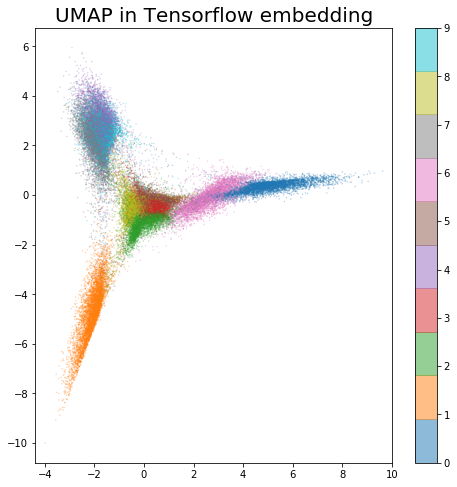

In [70]:
z = encoder(np.arange(len(X_train)))

fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

In [71]:
history = model.fit(
    edge_iter,
    epochs=10,     
)

Epoch 1/10


AssertionError: in user code:

    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:747 train_step
        y_pred = self(x, training=True)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/engine/functional.py:386 call
        inputs, training=training, mask=mask)
    /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/engine/functional.py:517 _run_internal_graph
        assert x_id in tensor_dict, 'Could not compute output ' + str(x)

    AssertionError: Could not compute output Tensor("umap/umap_3/Identity:0", shape=(None, 4), dtype=float32)


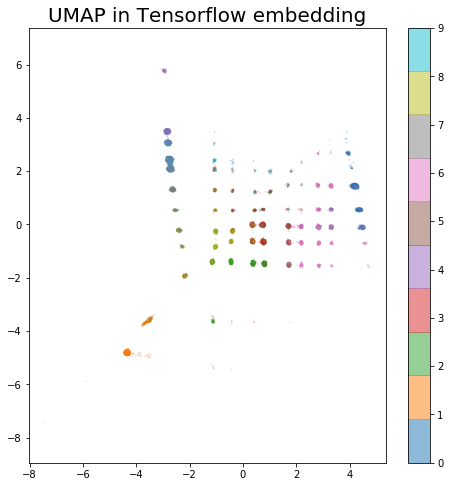

In [31]:
z = encoder(np.arange(len(X_train)))[:,-1,:]

fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);